In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

1600
1600


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '4', '1']
['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '0', '1']
['harem-ft', 'ELMo', '0', '2']
['harem-ft', 'ELMo', '0', '3']
['harem-ft', 'ELMo', '0', '4']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '1', '1']
['harem-ft', 'ELMo', '1', '2']
['harem-ft', 'ELMo', '1', '3']
['harem-ft', 'ELMo', '1', '4']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo', '2', '1']
['harem-ft', 'ELMo', '2', '2']
['harem-ft', 'ELMo', '2', '3']
['harem-ft', 'ELMo', '2', '4']
['harem-ft', 'ELMo', '3', '0']
['harem-ft', 'ELMo', '3', '1']
['harem-ft', 'ELMo', '3', '2']
['harem-ft', 'ELMo', '3', '3']
['harem-ft', 'ELMo', '3', '4']
['harem-ft', 'ELMo', '4', '0']
['harem-ft', 'ELMo', '4', '2']
['harem-ft', 'ELMo', '4', '3']
['harem-ft', 'ELMo', '4', '4']
['harem-ft', 'ELMo', '5', '0']
['harem-ft', 'ELMo', '5', '1']
['harem-ft', 'ELMo', '5', '2']
['harem-ft', 'ELMo', '5', '3']
['harem-ft', 'ELMo', '5', '4']
['harem-ft', 'ELMo', '6', '0']
['harem-ft', 'ELMo', '6', '1']
['harem-

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 9]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_4_1,harem-ft,ELMo,No,No,4,1,0,1,00:00:53,53.0,53.0,0.919394,0.926250,0.248677,0.178659,0.207932,260.210656,0.965825,0.968301,0.639798,0.609113,0.624079,92.424111,0.960690,0.963617,0.652602,0.619699,0.635725,93.739868
1,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,0,1,00:00:54,54.0,54.0,0.920402,0.926929,0.250925,0.182848,0.211544,258.282195,0.964813,0.967654,0.662125,0.619898,0.640316,84.979338,0.963842,0.966679,0.695122,0.647078,0.670240,89.557516
2,harem-ft_ELMo_0_1,harem-ft,ELMo,No,No,0,1,0,1,00:00:54,54.0,54.0,0.920391,0.926929,0.250277,0.182578,0.211134,258.282694,0.964813,0.967654,0.660326,0.619898,0.639474,85.008359,0.963797,0.966634,0.694126,0.647078,0.669777,89.524739
3,harem-ft_ELMo_0_2,harem-ft,ELMo,No,No,0,2,0,1,00:00:54,54.0,54.0,0.920380,0.926918,0.250648,0.182578,0.211265,258.286476,0.964813,0.967654,0.662125,0.619898,0.640316,85.000388,0.963782,0.966619,0.694405,0.646411,0.669549,89.537354
4,harem-ft_ELMo_0_3,harem-ft,ELMo,No,No,0,3,0,1,00:00:54,54.0,54.0,0.920369,0.926907,0.250278,0.182309,0.210953,258.279773,0.964813,0.967654,0.662125,0.619898,0.640316,84.998415,0.963797,0.966634,0.694763,0.646745,0.669895,89.535927
5,harem-ft_ELMo_0_4,harem-ft,ELMo,No,No,0,4,0,1,00:00:54,54.0,54.0,0.920380,0.926918,0.250741,0.182578,0.211298,258.286614,0.964813,0.967654,0.662125,0.619898,0.640316,84.993892,0.963842,0.966679,0.694873,0.647078,0.670124,89.535935
6,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,0,1,00:00:54,54.0,54.0,0.917791,0.924847,0.238828,0.171106,0.199373,260.592882,0.973013,0.974607,0.653061,0.668407,0.660645,72.125561,0.962477,0.965148,0.655302,0.641736,0.648448,93.243481
7,harem-ft_ELMo_1_1,harem-ft,ELMo,No,No,1,1,0,1,00:00:54,54.0,54.0,0.917813,0.924858,0.239188,0.171106,0.199498,260.586519,0.973013,0.974607,0.653061,0.668407,0.660645,72.083835,0.962462,0.965148,0.655514,0.641068,0.648211,93.211731
8,harem-ft_ELMo_1_2,harem-ft,ELMo,No,No,1,2,0,1,00:00:54,54.0,54.0,0.917802,0.924858,0.238828,0.171106,0.199373,260.590601,0.973013,0.974607,0.653061,0.668407,0.660645,72.095979,0.962462,0.965133,0.655067,0.641068,0.647992,93.203300
9,harem-ft_ELMo_1_3,harem-ft,ELMo,No,No,1,3,0,1,00:00:54,54.0,54.0,0.917870,0.924904,0.240240,0.172182,0.200596,260.599361,0.973213,0.974806,0.655612,0.671018,0.663226,72.056484,0.962477,0.965148,0.655184,0.641402,0.648220,93.178472


In [10]:
training_data_df[training_data_df.Embedding_Type == 'glove']

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss


In [11]:
training_data_df.to_csv('training_data_1_epoch_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:00:56.789375'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_1_epoch_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Não,800.0,66.387225,3.906394,49.192463,0.659095,0.674103,0.685239,71.010353
Sim,800.0,66.064797,3.183120,52.897069,0.658728,0.670723,0.678707,70.276859


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN+Vetor,700.0,66.771050,3.349223,54.269513,0.662899,0.675744,0.687359,70.808747
ELMo,100.0,66.086046,2.140022,60.672957,0.647351,0.661092,0.671948,69.675802
ELMo+Vetor,700.0,66.049582,3.886698,49.192463,0.662319,0.671510,0.679520,71.010353
ELMo+CNN,100.0,63.785705,2.560489,58.576549,0.619366,0.635922,0.651035,70.713904


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,600.0,67.680519,1.377237,62.535494,0.668545,0.676167,0.684842,71.010353
Sem Vetor,400.0,66.349163,2.547677,58.576549,0.648156,0.666490,0.682329,71.010353
CBoW,600.0,64.689402,4.819246,49.192463,0.605085,0.668813,0.678749,70.912649


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,400.0,67.775038,1.298230,63.486177,0.669424,0.677359,0.683535,71.010353
GloVe,200.0,67.762450,1.459328,64.213369,0.664982,0.677796,0.688110,71.010353
Word2Vec,400.0,67.754199,1.281622,65.422573,0.668848,0.675821,0.683258,70.912649
Sem Vetor,200.0,64.935875,2.620965,58.576549,0.634785,0.648220,0.667588,70.713904
FastText,400.0,63.025644,5.109173,49.192463,0.585748,0.656192,0.673325,70.472163


In [18]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+CNN+Vetor Word2Vec  CBoW               50.0  68.528130   
                                     Skip-Gram          50.0  68.427651   
            ELMo+Vetor     Wang2Vec  Skip-Gram          50.0  68.279292   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0  68.243964   
                           GloVe     Sem Vetor          50.0  68.224724   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW               50.0  68.134070   
            ELMo+Vetor     GloVe     Sem Vetor          50.0  68.082414   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0  68.057791   
            ELMo+Vetor     FastText  Skip-Gram          50.0  67.844770   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW               50.0  67.782408   
                           Wang2Vec  CBoW               50.0  67.749547   
                           Word2Vec  Skip-Gram          50.0  67.715210   
Não         ELMo+Vetor     Word2Vec  CBoW               50.0  67.652241   
            ELMo+CNN+Vetor GloVe     Sem Vetor          50.0  67.633405   
Sim         ELMo+CNN+Vetor FastText  Skip-Gram          50.0  67.542383   
Não         ELMo+Vetor     Wang2Vec  CBoW               50.0  67.507867   
                           Word2Vec  Skip-Gram          50.0  67.373488   
Sim         ELMo+Vetor     Word2Vec  CBoW               50.0  67.326037   
Não         ELMo+CNN+Vetor FastText  Skip-Gram          50.0  67.236924   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram          50.0  67.228422   
Não         ELMo           Sem Vetor Sem Vetor          50.0  67.204308   
Sim         ELMo+Vetor     Wang2Vec  CBoW               50.0  67.117893   
                                     Skip-Gram          50.0  67.109883   
                           GloVe     Sem Vetor          50.0  67.109256   
                           FastText  Skip-Gram          50.0  67.106451   
            ELMo           Sem Vetor Sem Vetor          50.0  64.967783   
Não         ELMo+CNN       Sem Vetor Sem Vetor          50.0  64.516770   
Sim         ELMo+CNN       Sem Vetor Sem Vetor          50.0  63.054641   
            ELMo+CNN+Vetor FastText  CBoW               50.0  60.185656   
Não         ELMo+CNN+Vetor FastText  CBoW               50.0  59.332833   
Sim         ELMo+Vetor     FastText  CBoW               50.0  58.572500   
Não         ELMo+Vetor     FastText  CBoW               50.0  56.383639   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+CNN+Vetor Word2Vec  CBoW                1.460740  65.595178   
                                     Skip-Gram           1.479820  65.476591   
            ELMo+Vetor     Wang2Vec  Skip-Gram           1.299813  66.255678   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.905548  66.755942   
                           GloVe     Sem Vetor           1.163968  65.862069   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW                1.536382  64.827128   
            ELMo+Vetor     GloVe     Sem Vetor           1.289522  66.301193   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.800250  63.486177   
            ELMo+Vetor     FastText  Skip-Gram           1.211562  66.089796   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW                1.094827  65.796255   
                           Wang2Vec  CBoW                0.985386  66.289243   
                           Word2Vec  Skip-Gram           1.102499  65.497076   
Não         ELMo+Vetor     Word2Vec  CBoW                1.316248  65.828243   
            ELMo+CNN+Vetor GloVe     Sem Vetor           1.806496  64.213369   
Sim         ELMo+CNN+Vetor FastText  Skip-Gram           1.122784  65.278734   
Não         ELMo+Vetor     Wang2Vec  CBoW                1.270288  66.016577   
                           Word2Vec  Skip-Gram           1.41

In [19]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,200.0,0.679227,0.013596,0.634862,0.671036,0.680057,0.687020,0.710104
word2vec,cbow,200.0,0.678222,0.012300,0.655952,0.671521,0.676096,0.683172,0.709126
glove,No,200.0,0.677624,0.014593,0.642134,0.664982,0.677796,0.688110,0.710104
word2vec,skip,200.0,0.676862,0.013308,0.654226,0.668258,0.674697,0.683557,0.708103
wang2vec,cbow,200.0,0.676273,0.012194,0.648271,0.666859,0.675440,0.681537,0.705903
fasttext,skip,200.0,0.674326,0.014032,0.625355,0.663817,0.673334,0.683281,0.704722
No,No,200.0,0.649359,0.026210,0.585765,0.634785,0.648220,0.667588,0.707139
fasttext,cbow,200.0,0.586187,0.033662,0.491925,0.566134,0.585714,0.604675,0.662712


In [20]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,200.0,0.679227,0.013596,0.634862,0.671036,0.680057,0.687020,0.710104
glove,200.0,0.677624,0.014593,0.642134,0.664982,0.677796,0.688110,0.710104
word2vec,200.0,0.676862,0.013308,0.654226,0.668258,0.674697,0.683557,0.708103
fasttext,200.0,0.674326,0.014032,0.625355,0.663817,0.673334,0.683281,0.704722
No,200.0,0.649359,0.026210,0.585765,0.634785,0.648220,0.667588,0.707139


In [21]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec,200.0,0.678222,0.012300,0.655952,0.671521,0.676096,0.683172,0.709126
glove,200.0,0.677624,0.014593,0.642134,0.664982,0.677796,0.688110,0.710104
wang2vec,200.0,0.676273,0.012194,0.648271,0.666859,0.675440,0.681537,0.705903
No,200.0,0.649359,0.026210,0.585765,0.634785,0.648220,0.667588,0.707139
fasttext,200.0,0.586187,0.033662,0.491925,0.566134,0.585714,0.604675,0.662712


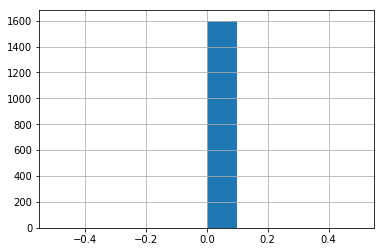

In [22]:
training_data_df[BEST_EPOCH].hist()

In [23]:
training_data_df[TOTAL_DURATION].describe()

count    1600.000000
mean       56.789375
std         2.809795
min        53.000000
25%        54.000000
50%        58.000000
75%        59.000000
max        63.000000
Name: Total_Duration(s), dtype: float64

In [24]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
9,160.0,0.689851,0.019043,0.633462,0.678069,0.696719,0.705325,0.710104
0,160.0,0.669280,0.031790,0.563992,0.669110,0.681382,0.686682,0.698819
5,160.0,0.661533,0.033664,0.579898,0.658948,0.672263,0.681487,0.702629
2,160.0,0.661427,0.029485,0.548628,0.663672,0.669916,0.677642,0.690284
6,160.0,0.660720,0.031848,0.553547,0.663381,0.672889,0.677792,0.691665
3,160.0,0.660582,0.036026,0.555407,0.660191,0.670365,0.680439,0.697643
8,160.0,0.660052,0.036373,0.544841,0.657629,0.664988,0.682008,0.705101
7,160.0,0.656373,0.036428,0.554422,0.653081,0.666036,0.678641,0.696483
1,160.0,0.656356,0.029137,0.566137,0.649360,0.665181,0.674962,0.685024


In [25]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,1600.0,0.66226,0.035657,0.000891,0.660512,0.664009


In [26]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,200,0.649359,0.026210,0.001853,0.645726,0.652991
fasttext,400,0.630256,0.051092,0.002555,0.625249,0.635263
glove,200,0.677624,0.014593,0.001032,0.675602,0.679647
wang2vec,400,0.677750,0.012982,0.000649,0.676478,0.679023
word2vec,400,0.677542,0.012816,0.000641,0.676286,0.678798


In [27]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [28]:
print_anova(EMBEDDING)

Overall model F( 4, 1595) =  200.226, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     200.2
Date:                Mon, 10 Jun 2019   Prob (F-statistic):          3.18e-139
Time:                        12:03:52   Log-Likelihood:                 3389.8
No. Observations:                1600   AIC:                            -6770.
Df Residuals:                    1595   BIC:                            -6743.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [29]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
623,harem-ft_ELMo+Embeddings_wang2vec_skip_0_1,harem-ft,ELMo+Embeddings,wang2vec,skip,0,1,0,1,00:00:54,54.0,54.0,0.914916,0.921454,0.216232,0.203344,0.209590,257.984616,0.962627,0.965578,0.628788,0.635204,0.631980,85.520127,0.963662,0.966409,0.676370,0.659432,0.667794,88.602717
624,harem-ft_ELMo+Embeddings_wang2vec_skip_0_2,harem-ft,ELMo+Embeddings,wang2vec,skip,0,2,0,1,00:00:54,54.0,54.0,0.915017,0.921544,0.217404,0.204153,0.210570,257.997770,0.962627,0.965578,0.628788,0.635204,0.631980,85.454563,0.963557,0.966304,0.674649,0.658431,0.666441,88.601159
625,harem-ft_ELMo+Embeddings_wang2vec_skip_0_3,harem-ft,ELMo+Embeddings,wang2vec,skip,0,3,0,1,00:00:54,54.0,54.0,0.914916,0.921454,0.216294,0.203344,0.209619,257.988487,0.962627,0.965578,0.628788,0.635204,0.631980,85.531922,0.963572,0.966334,0.675796,0.659098,0.667343,88.609573
626,harem-ft_ELMo+Embeddings_wang2vec_skip_0_4,harem-ft,ELMo+Embeddings,wang2vec,skip,0,4,0,1,00:00:54,54.0,54.0,0.914939,0.921477,0.216581,0.203614,0.209897,257.989212,0.962627,0.965578,0.628788,0.635204,0.631980,85.500942,0.963602,0.966364,0.675907,0.659432,0.667568,88.581295
627,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,0,1,00:00:55,55.0,55.0,0.911707,0.918571,0.197399,0.183750,0.190330,262.056492,0.973710,0.975602,0.670854,0.697128,0.683739,71.341419,0.964143,0.966784,0.669939,0.660768,0.665322,90.476974
628,harem-ft_ELMo+Embeddings_wang2vec_skip_1_1,harem-ft,ELMo+Embeddings,wang2vec,skip,1,1,0,1,00:00:54,54.0,54.0,0.911560,0.918469,0.196186,0.182674,0.189189,262.092637,0.973910,0.975802,0.677582,0.702350,0.689744,71.206031,0.964353,0.966964,0.676042,0.666110,0.671039,90.353786
629,harem-ft_ELMo+Embeddings_wang2vec_skip_1_2,harem-ft,ELMo+Embeddings,wang2vec,skip,1,2,0,1,00:00:54,54.0,54.0,0.911673,0.918537,0.196702,0.182943,0.189573,262.068707,0.973810,0.975802,0.673367,0.699739,0.686300,71.207511,0.964098,0.966754,0.672986,0.663773,0.668348,90.421878
630,harem-ft_ELMo+Embeddings_wang2vec_skip_1_3,harem-ft,ELMo+Embeddings,wang2vec,skip,1,3,0,1,00:00:54,54.0,54.0,0.911594,0.918481,0.196589,0.182943,0.189521,262.077700,0.973910,0.975802,0.677582,0.702350,0.689744,71.289781,0.964038,0.966679,0.669033,0.660768,0.664875,90.422406
631,harem-ft_ELMo+Embeddings_wang2vec_skip_1_4,harem-ft,ELMo+Embeddings,wang2vec,skip,1,4,0,1,00:00:54,54.0,54.0,0.911628,0.918515,0.196186,0.182674,0.189189,262.092628,0.973710,0.975602,0.674242,0.697128,0.685494,71.196773,0.964218,0.966874,0.674458,0.664775,0.669581,90.371089
632,harem-ft_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft,ELMo+Embeddings,wang2vec,skip,2,0,0,1,00:00:56,56.0,56.0,0.914302,0.920845,0.203156,0.198677,0.200892,253.944235,0.967507,0.969041,0.704017,0.707006,0.705508,99.108210,0.964713,0.967024,0.698279,0.663773,0.680589,90.222916
